In [1]:
cd("/Users/evanrussek/foraging/")

using CSV
using DataFrames
using DataFramesMeta
using CategoricalArrays
using Gadfly
using Statistics
using Distributions
using SpecialFunctions
using StatsFuns
using Optim
using ForwardDiff

include("sim_lag_functions.jl")
include("sim_learn_funcs.jl")

make_recov_df (generic function with 1 method)

In [2]:
param_dict = Dict();
param_dict["harvest_cost"] = 1.;#.1 + 10*rand();
param_dict["travel_cost_easy"] = 2.;#param_dict["harvest_cost"] + 5*rand();
param_dict["travel_cost_hard"] = 8.#;param_dict["travel_cost_easy"] + 8*rand();
param_dict["r_hat_start_reward_weight"] = .2;#.01 + .4*rand()
param_dict["r_hat_start_easy_weight"] = 1;#.01 * 10*rand();
param_dict["harvest_lag_hat_start"] = 2.#.01 + rand()*5;#1.0; # don't fit this...
param_dict["harvest_bias"] = 0;#100;#-10 + rand()*20;
param_dict["choice_beta"] = 4.; #.001 + rand()*5;
param_dict["lag_beta"] = 2.;#.001 + rand()*8.;
param_dict["lr_R_hat_pre"] = -2.7;#-4. + 4*rand();
param_dict["lr_harvest_lag_hat_pre"] = -2.;#-4 + 5*rand();
transform_lr(param_dict["lr_R_hat_pre"])

# show original params
param_dict

#

Dict{Any,Any} with 11 entries:
  "harvest_bias"              => 0
  "travel_cost_hard"          => 8.0
  "r_hat_start_easy_weight"   => 1
  "r_hat_start_reward_weight" => 0.2
  "choice_beta"               => 4.0
  "harvest_lag_hat_start"     => 2.0
  "lr_harvest_lag_hat_pre"    => -2.0
  "harvest_cost"              => 1.0
  "lag_beta"                  => 2.0
  "travel_cost_easy"          => 2.0
  "lr_R_hat_pre"              => -2.7

In [3]:
# simulate tasks and make plots
sim_df = sim_forage_learn(param_dict);

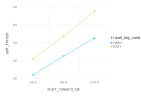

In [4]:
make_exit_plot(sim_df)

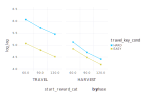

In [5]:
make_lag_plot(sim_df)



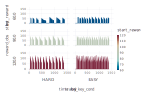

In [6]:
plot(sim_df, x = :time, y = :reward_obs, xgroup = :travel_key_cond,ygroup = :start_reward, color = :start_reward,
    Geom.subplot_grid(Geom.line))

#

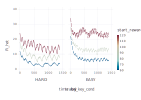

In [7]:
plot(sim_df, x = :time, y = :R_hat, xgroup = :travel_key_cond,
    group = :trial_num, color = :start_reward, linestyle = :travel_key_cond,
    Geom.subplot_grid(Geom.line))



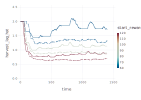

In [8]:
plot(sim_df, x = :time, y = :harvest_lag_hat, group = :trial_num, color = :start_reward,
 linestyle = :travel_key_cond, Geom.line)

 #

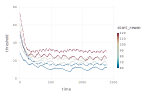

In [9]:
plot(sim_df, x = :time, y = :threshold, group = :trial_num, color = :start_reward,
    linestyle = :travel_key_cond, Geom.line)


#

In [10]:
param_names = [];
param_vals = Float64[];
for (k,v) in param_dict
    #println(k,v)
    push!(param_names, k)
    push!(param_vals, v)
end
print(param_names) # check that this matches the order in the likelihood function...
include("sim_learn_funcs.jl")


#

Any["harvest_bias", "travel_cost_hard", "r_hat_start_easy_weight", "r_hat_start_reward_weight", "choice_beta", "harvest_lag_hat_start", "lr_harvest_lag_hat_pre", "harvest_cost", "lag_beta", "travel_cost_easy", "lr_R_hat_pre"]

make_recov_df (generic function with 1 method)

In [16]:
start_p = generate_start_vals((x) -> forage_learn_lik2(x,sim_df,"both"))

# check that we can take the gradient at the first value...
#ForwardDiff.gradient(cost_fun,start_x)

#

11-element Array{Float64,1}:
 -1.4761422367741412 
  0.24747075954558984
  1.2743539950255784 
  2.654139028861427  
  5.426716753157379  
  1.079303327207998  
 -7.520888331187117  
  5.366841364460649  
  0.618266005815334  
  4.050492480399404  
 -9.662347642536208  

In [17]:
# fit the simulated data.
a_both = optimize(
    (x) -> forage_learn_lik2(x,sim_df, "both"),start_p, LBFGS(),
    Optim.Options(allow_f_increases=true, iterations = 4000, show_trace = false),
    autodiff=:forward)

# fit the simulated data.
a_choice = optimize(
    (x) -> forage_learn_lik2(x,sim_df, "choice"),start_p, LBFGS(),
    Optim.Options(allow_f_increases=true, iterations = 4000, show_trace = false),
    autodiff=:forward)

# fit the simulated data.
a_lag = optimize(
    (x) -> forage_learn_lik2(x,sim_df, "lag"),start_p, LBFGS(),
    Optim.Options(allow_f_increases=true, iterations = 4000, show_trace = false),
    autodiff=:forward);

#

 * Status: success

 * Candidate solution
    Minimizer: [-1.48e+00, 5.27e+01, 1.83e+00,  ...]
    Minimum:   -1.334359e+02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [-1.48e+00, 2.47e-01, 1.27e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.49e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.04e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.26e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.94e-14 ≰ 0.0e+00
    |g(x)|                 = 9.08e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    43
    f(x) calls:    173
    ∇f(x) calls:   173


In [18]:
fit_df_both = make_recov_df(a_both,param_names,param_dict, (x) -> forage_learn_lik2(x,sim_df,"both"))

#

11×5 DataFrame. Omitted printing of 1 columns
│ Row │ pname                     │ original_val │ recovered_val │ orig_nll │
│     │ Any                       │ Float64      │ Float64       │ Float64  │
├─────┼───────────────────────────┼──────────────┼───────────────┼──────────┤
│ 1   │ harvest_bias              │ 0.0          │ 12.9648       │ 10667.5  │
│ 2   │ travel_cost_hard          │ 8.0          │ 19.2168       │ 10667.5  │
│ 3   │ r_hat_start_easy_weight   │ 1.0          │ 0.668047      │ 10667.5  │
│ 4   │ r_hat_start_reward_weight │ 0.2          │ 0.263559      │ 10667.5  │
│ 5   │ choice_beta               │ 4.0          │ -0.00168389   │ 10667.5  │
│ 6   │ harvest_lag_hat_start     │ 2.0          │ -0.0039281    │ 10667.5  │
│ 7   │ lr_harvest_lag_hat_pre    │ -2.0         │ -7.52089      │ 10667.5  │
│ 8   │ harvest_cost              │ 1.0          │ 2.05528       │ 10667.5  │
│ 9   │ lag_beta                  │ 2.0          │ 0.331466      │ 10667.5  │
│ 10  │ travel_cost_easy          │ 2.0          │ 3.69987       │ 10667.5  │
│ 11  │ lr_R_hat_pre              │ -2.7         │ -9.66235      │ 10667.5  │

In [19]:
fit_df_choice = make_recov_df(a_choice,param_names,param_dict, (x) -> forage_learn_lik2(x,sim_df,"choice"))
#

11×5 DataFrame. Omitted printing of 1 columns
│ Row │ pname                     │ original_val │ recovered_val │ orig_nll │
│     │ Any                       │ Float64      │ Float64       │ Float64  │
├─────┼───────────────────────────┼──────────────┼───────────────┼──────────┤
│ 1   │ harvest_bias              │ 0.0          │ -1.4715       │ 14204.2  │
│ 2   │ travel_cost_hard          │ 8.0          │ 0.247471      │ 14204.2  │
│ 3   │ r_hat_start_easy_weight   │ 1.0          │ 1.11458       │ 14204.2  │
│ 4   │ r_hat_start_reward_weight │ 0.2          │ 4.85945e-16   │ 14204.2  │
│ 5   │ choice_beta               │ 4.0          │ 4.02162       │ 14204.2  │
│ 6   │ harvest_lag_hat_start     │ 2.0          │ -4.47528      │ 14204.2  │
│ 7   │ lr_harvest_lag_hat_pre    │ -2.0         │ -7.52089      │ 14204.2  │
│ 8   │ harvest_cost              │ 1.0          │ 5.13337       │ 14204.2  │
│ 9   │ lag_beta                  │ 2.0          │ 0.618266      │ 14204.2  │
│ 10  │ travel_cost_easy          │ 2.0          │ 4.05049       │ 14204.2  │
│ 11  │ lr_R_hat_pre              │ -2.7         │ -9.66235      │ 14204.2  │

In [20]:
fit_df_lag = make_recov_df(a_lag,param_names,param_dict, (x) -> forage_learn_lik2(x,sim_df,"lag"))


11×5 DataFrame. Omitted printing of 1 columns
│ Row │ pname                     │ original_val │ recovered_val │ orig_nll │
│     │ Any                       │ Float64      │ Float64       │ Float64  │
├─────┼───────────────────────────┼──────────────┼───────────────┼──────────┤
│ 1   │ harvest_bias              │ 0.0          │ -1.47614      │ -3536.64 │
│ 2   │ travel_cost_hard          │ 8.0          │ 52.707        │ -3536.64 │
│ 3   │ r_hat_start_easy_weight   │ 1.0          │ 1.83227       │ -3536.64 │
│ 4   │ r_hat_start_reward_weight │ 0.2          │ 0.722877      │ -3536.64 │
│ 5   │ choice_beta               │ 4.0          │ 5.42672       │ -3536.64 │
│ 6   │ harvest_lag_hat_start     │ 2.0          │ 1.0793        │ -3536.64 │
│ 7   │ lr_harvest_lag_hat_pre    │ -2.0         │ -7.52089      │ -3536.64 │
│ 8   │ harvest_cost              │ 1.0          │ 5.63713       │ -3536.64 │
│ 9   │ lag_beta                  │ 2.0          │ 0.120852      │ -3536.64 │
│ 10  │ travel_cost_easy          │ 2.0          │ 10.1478       │ -3536.64 │
│ 11  │ lr_R_hat_pre              │ -2.7         │ -9.66235      │ -3536.64 │

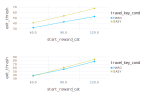

In [30]:
p_hat_both = a_both.minimizer
p_hat_dict_both = Dict()
for j in 1:length(param_names)
    p_hat_dict_both[param_names[j]] = p_hat_both[j]
end

# compare plots of orig_vals, recovered vals...
sim_df_rec_both = sim_forage_learn(p_hat_dict_both);
p_rec_choice = make_exit_plot(sim_df_rec_both)
p_orig_choice = make_exit_plot(sim_df)
vstack([p_orig_choice; p_rec_choice])

## this is leaving much earlier than it should...

UndefVarError: UndefVarError: sim_df_rec_both not defined

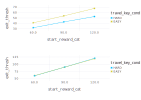

In [24]:
p_hat_lag = a_lag.minimizer
p_hat_dict_lag = Dict()
for j in 1:length(param_names)
    p_hat_dict_lag[param_names[j]] = p_hat_lag[j]
end

# compare plots of orig_vals, recovered vals...
sim_df_rec_lag = sim_forage_learn(p_hat_dict_lag);
p_rec_choice = make_exit_plot(sim_df_rec_lag)
p_orig_choice = make_exit_plot(sim_df)
vstack([p_orig_choice; p_rec_choice])

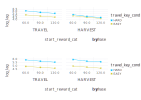

In [25]:
# the lag looks correct...
p_rec_lag = make_lag_plot(sim_df_rec_lag)
p_orig_lag = make_lag_plot(sim_df)
vstack([p_orig_lag; p_rec_lag])

In [ ]:
### 


#### let's get rid of the harvest lag prediction stuff...












# o use python's scipy.optimize...
#so = pyimport("scipy.optimize")
#@time a = so.minimize(cost_fun, start_x, method="L-BFGS-B", jac = (x->ForwardDiff.gradient(cost_fun,x)))

p_hat_dict = Dict()
for j in 1:length(param_names)
    p_hat_dict[param_names[j]] = p_hat[j]
end

# compare plots of orig_vals, recovered vals...
sim_df_rec = sim_forage_learn(p_hat_dict);
p_rec_choice = make_exit_plot(sim_df_rec)
p_orig_choice = make_exit_plot(sim_df)
vstack([p_orig_choice; p_rec_choice])

# the lag looks correct...
p_rec_lag = make_lag_plot(sim_df_rec)
p_orig_lag = make_lag_plot(sim_df)
vstack([p_orig_lag; p_rec_lag])


plot(sim_df_rec, x = :time, y = :R_hat, xgroup = :travel_key_cond,
    group = :trial_num, color = :start_reward, linestyle = :travel_key_cond,
    Geom.subplot_grid(Geom.line), Guide.title("Recovered Params"))

    plot(sim_df, x = :time, y = :R_hat, xgroup = :travel_key_cond,
        group = :trial_num, color = :start_reward, linestyle = :travel_key_cond,
        Geom.subplot_grid(Geom.line), Guide.title("Original Params"))